[View in Colaboratory](https://colab.research.google.com/github/stikbuf/Language_Modeling/blob/master/Keras_Character_Aware_Neural_Language_Models.ipynb)

## Configure the cloud environment


### Mount Google Drive

In [ ]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
# If you got a "Transport endpoint is not connected." error. Please run this line first to unmount the drive.
# See https://stackoverflow.com/questions/49588113/google-colab-script-throws-transport-endpoint-is-not-connected?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
!fusermount -u drive

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive
a = !ls drive/
print('Files in Drive:', a)
assert a!=[], 'Drive should not be empty!'

In [ ]:
local_path='./drive/share_with_me/AI/Character-aware_LM/'
#local_path='./'
import sys
sys.path.append(local_path)
!ls './drive/share_with_me/AI/Character-aware_LM/'

In [ ]:
import tensorflow as tf
#assert tf.test.gpu_device_name() != '', "GPU not avaliable!"
tf.test.gpu_device_name()

## Load data

In [1]:
local_path='./'

In [2]:
from __future__ import print_function
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd

from reader import ptb_raw_data, ptb_producer # by Google

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
train_data, valid_data, test_data, word_to_id = ptb_raw_data(local_path + 'data')
id_to_word = dict((v, k) for k, v in word_to_id.items())
voc_size = len(id_to_word)
voc_size

10000

In [4]:
id_to_word[voc_size]='<START>'
id_to_word[voc_size+1]='<END>'
word_to_id = dict((v, k) for k, v in id_to_word.items())
voc_size = len(id_to_word)
voc_size

10002

In [5]:
word_id = pd.DataFrame.from_dict(word_to_id, orient='index').sort_values(by=0, ascending=True)
word_id.columns = ['id']
print(word_id.head())
print(word_id.tail())

       id
the     0
<unk>   1
<eos>   2
N       3
of      4
              id
ssangyong   9997
swapo       9998
wachter     9999
<START>    10000
<END>      10001


In [6]:
id_word = pd.DataFrame.from_dict(id_to_word, orient='index')
id_word.columns = ['word']
print(id_word.head())
print(id_word.tail())

    word
0    the
1  <unk>
2  <eos>
3      N
4     of
            word
9997   ssangyong
9998       swapo
9999     wachter
10000    <START>
10001      <END>


In [7]:
' '.join([id_to_word[id] for id in train_data[:30]])

'aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old'

## RNN baseline

In [8]:
import random
seq_len = 35

from tensorflow.python.keras.utils import to_categorical # 源码值得一读

def gen_word_word(batch_size=128, dataset='train'):
    assert dataset in ['train', 'valid', 'test'], 'Dataset must be train or valid or test.'
    
    dic = {'train':train_data, 'valid':valid_data, 'test':test_data}
    data = dic[dataset]
    
    while True:
        rnd_idxs = list(range(len(data)-seq_len-1))
        random.shuffle(rnd_idxs)
        cnt = 0
        while cnt < len(rnd_idxs) - batch_size :
            X = np.array([[word_to_id['<START>']] + data[i:i+seq_len] + [word_to_id['<END>']]
                          for i in rnd_idxs[cnt:cnt+batch_size]])
            Y = X[:,1:]
            X = X[:,:-1]
            Y = to_categorical(Y)
            #print(X.shape)
            cnt += batch_size
            yield X, Y

In [9]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import GRU, Dense, Embedding, InputLayer
from tensorflow.python.keras.optimizers import RMSprop

In [10]:
model = Sequential()

embedding_size = 128


model.add(Embedding(input_dim=voc_size,
                    output_dim=embedding_size,
                    name='inputEmbedding'))
model.add(GRU(units=128, return_sequences=True))
model.add(GRU(units=64, return_sequences=True))
model.add(Dense(voc_size, activation='softmax'))

In [11]:
# perplexity
def PPL(y_true, y_pred):
    return tf.exp(tf.reduce_mean(tf.keras.backend.categorical_crossentropy(y_true, y_pred)))

def ACC(y_true, y_pred):
    ACC = tf.equal(tf.argmax(y_true, axis = 2), 
                   tf.argmax(y_pred, axis = 2))
    ACC = tf.cast(ACC, tf.float32)

    return tf.reduce_mean(ACC)

In [12]:
optimizer = RMSprop(lr=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[ACC, PPL])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputEmbedding (Embedding)   (None, None, 128)         1280256   
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
gru_2 (GRU)                  (None, None, 64)          37056     
_________________________________________________________________
dense_1 (Dense)              (None, None, 10002)       650130    
Total params: 2,066,130
Trainable params: 2,066,130
Non-trainable params: 0
_________________________________________________________________


In [14]:
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint
import os
if not os.path.exists(local_path + 'model/'):
    os.mkdir(local_path + 'model/')

path_model = local_path + 'model/model.keras'    
tensorboard = TensorBoard(log_dir='log')
checkpoint = ModelCheckpoint(filepath=path_model, verbose=1,
                             monitor='val_PPL',mode='min' ,save_best_only='True')
# path_model = local_path + 'model/model.keras'
# model.save(path_model)

callback_lists=[tensorboard,checkpoint]

In [ ]:
hist = model.fit_generator(generator=gen_word_word(), 
                           steps_per_epoch=50, epochs=200,
                           callbacks=callback_lists,
                           validation_data=gen_word_word(dataset='valid'),
                           validation_steps=30)

Epoch 1/1000
49/50 [============================>.] - ETA: 0s - loss: 7.4000 - ACC: 0.0513 - PPL: 2214.5359
Epoch 00001: val_PPL improved from inf to 731.97500, saving model to ./model/model.keras
50/50 [==============================] - 27s 548ms/step - loss: 7.3832 - ACC: 0.0513 - PPL: 2184.3923 - val_loss: 6.5952 - val_ACC: 0.0553 - val_PPL: 731.9750
Epoch 2/1000
49/50 [============================>.] - ETA: 0s - loss: 6.5144 - ACC: 0.0528 - PPL: 675.5431
Epoch 00002: val_PPL improved from 731.97500 to 665.90202, saving model to ./model/model.keras
50/50 [==============================] - 26s 523ms/step - loss: 6.5146 - ACC: 0.0528 - PPL: 675.6792 - val_loss: 6.5002 - val_ACC: 0.0547 - val_PPL: 665.9020
Epoch 3/1000
49/50 [============================>.] - ETA: 0s - loss: 6.4834 - ACC: 0.0536 - PPL: 654.6731
Epoch 00003: val_PPL improved from 665.90202 to 636.69698, saving model to ./model/model.keras
50/50 [==============================] - 26s 524ms/step - loss: 6.4813 - ACC: 0.05

Epoch 48/1000
49/50 [============================>.] - ETA: 0s - loss: 5.0752 - ACC: 0.2170 - PPL: 160.3917
Epoch 00048: val_PPL improved from 188.93332 to 187.60072, saving model to ./model/model.keras
50/50 [==============================] - 26s 527ms/step - loss: 5.0761 - ACC: 0.2167 - PPL: 160.5452 - val_loss: 5.2329 - val_ACC: 0.2076 - val_PPL: 187.6007
Epoch 49/1000
49/50 [============================>.] - ETA: 0s - loss: 5.0732 - ACC: 0.2163 - PPL: 159.9714
Epoch 00049: val_PPL improved from 187.60072 to 184.65786, saving model to ./model/model.keras
50/50 [==============================] - 26s 527ms/step - loss: 5.0730 - ACC: 0.2163 - PPL: 159.9388 - val_loss: 5.2163 - val_ACC: 0.2107 - val_PPL: 184.6579
Epoch 50/1000
49/50 [============================>.] - ETA: 0s - loss: 5.0511 - ACC: 0.2175 - PPL: 156.5475
Epoch 00050: val_PPL did not improve
50/50 [==============================] - 26s 527ms/step - loss: 5.0528 - ACC: 0.2172 - PPL: 156.8148 - val_loss: 5.2280 - val_ACC: 0.

Epoch 73/1000
49/50 [============================>.] - ETA: 0s - loss: 4.8876 - ACC: 0.2333 - PPL: 133.0550
Epoch 00073: val_PPL improved from 168.01959 to 167.92306, saving model to ./model/model.keras
50/50 [==============================] - 27s 535ms/step - loss: 4.8843 - ACC: 0.2335 - PPL: 132.6358 - val_loss: 5.1212 - val_ACC: 0.2197 - val_PPL: 167.9231
Epoch 74/1000
49/50 [============================>.] - ETA: 0s - loss: 4.8759 - ACC: 0.2353 - PPL: 131.5250
Epoch 00074: val_PPL improved from 167.92306 to 166.24266, saving model to ./model/model.keras
50/50 [==============================] - 26s 527ms/step - loss: 4.8767 - ACC: 0.2351 - PPL: 131.6281 - val_loss: 5.1102 - val_ACC: 0.2246 - val_PPL: 166.2427
Epoch 75/1000
49/50 [============================>.] - ETA: 0s - loss: 4.8703 - ACC: 0.2342 - PPL: 130.7462
Epoch 00075: val_PPL did not improve
50/50 [==============================] - 26s 527ms/step - loss: 4.8713 - ACC: 0.2341 - PPL: 130.8717 - val_loss: 5.1246 - val_ACC: 0.

Epoch 99/1000
49/50 [============================>.] - ETA: 0s - loss: 4.7671 - ACC: 0.2434 - PPL: 117.8236
Epoch 00099: val_PPL did not improve
50/50 [==============================] - 26s 529ms/step - loss: 4.7672 - ACC: 0.2434 - PPL: 117.8275 - val_loss: 5.0698 - val_ACC: 0.2235 - val_PPL: 159.4389
Epoch 100/1000
49/50 [============================>.] - ETA: 0s - loss: 4.7735 - ACC: 0.2436 - PPL: 118.6141
Epoch 00100: val_PPL did not improve
50/50 [==============================] - 26s 527ms/step - loss: 4.7745 - ACC: 0.2436 - PPL: 118.7383 - val_loss: 5.0546 - val_ACC: 0.2271 - val_PPL: 157.1786
Epoch 101/1000
49/50 [============================>.] - ETA: 0s - loss: 4.7435 - ACC: 0.2462 - PPL: 115.0628
Epoch 00101: val_PPL did not improve
50/50 [==============================] - 26s 527ms/step - loss: 4.7467 - ACC: 0.2458 - PPL: 115.4484 - val_loss: 5.0863 - val_ACC: 0.2236 - val_PPL: 162.3085
Epoch 102/1000
49/50 [============================>.] - ETA: 0s - loss: 4.7552 - ACC: 0.2

Epoch 151/1000
49/50 [============================>.] - ETA: 0s - loss: 4.5654 - ACC: 0.2628 - PPL: 96.2929
Epoch 00151: val_PPL did not improve
50/50 [==============================] - 26s 528ms/step - loss: 4.5669 - ACC: 0.2626 - PPL: 96.4403 - val_loss: 5.0004 - val_ACC: 0.2346 - val_PPL: 148.9132
Epoch 152/1000
49/50 [============================>.] - ETA: 0s - loss: 4.5827 - ACC: 0.2600 - PPL: 98.1072
Epoch 00152: val_PPL did not improve
50/50 [==============================] - 26s 527ms/step - loss: 4.5822 - ACC: 0.2599 - PPL: 98.0500 - val_loss: 5.0304 - val_ACC: 0.2299 - val_PPL: 153.5709
Epoch 153/1000
49/50 [============================>.] - ETA: 0s - loss: 4.5574 - ACC: 0.2625 - PPL: 95.5757
Epoch 00153: val_PPL did not improve
50/50 [==============================] - 26s 527ms/step - loss: 4.5581 - ACC: 0.2624 - PPL: 95.6460 - val_loss: 5.0073 - val_ACC: 0.2357 - val_PPL: 150.0190
Epoch 154/1000
49/50 [============================>.] - ETA: 0s - loss: 4.5714 - ACC: 0.2624 -

Epoch 178/1000
49/50 [============================>.] - ETA: 0s - loss: 4.4977 - ACC: 0.2689 - PPL: 90.0580
Epoch 00178: val_PPL did not improve
50/50 [==============================] - 26s 528ms/step - loss: 4.4975 - ACC: 0.2689 - PPL: 90.0362 - val_loss: 4.9793 - val_ACC: 0.2383 - val_PPL: 146.0631
Epoch 179/1000
49/50 [============================>.] - ETA: 0s - loss: 4.5241 - ACC: 0.2667 - PPL: 92.4471
Epoch 00179: val_PPL did not improve
50/50 [==============================] - 26s 528ms/step - loss: 4.5236 - ACC: 0.2668 - PPL: 92.4027 - val_loss: 4.9925 - val_ACC: 0.2360 - val_PPL: 148.0972
Epoch 180/1000
49/50 [============================>.] - ETA: 0s - loss: 4.4953 - ACC: 0.2698 - PPL: 89.7908
Epoch 00180: val_PPL did not improve
50/50 [==============================] - 26s 527ms/step - loss: 4.4949 - ACC: 0.2699 - PPL: 89.7503 - val_loss: 5.0048 - val_ACC: 0.2369 - val_PPL: 149.3731
Epoch 181/1000
49/50 [============================>.] - ETA: 0s - loss: 4.4835 - ACC: 0.2699 -

49/50 [============================>.] - ETA: 0s - loss: 4.3898 - ACC: 0.2806 - PPL: 80.8016
Epoch 00232: val_PPL did not improve
50/50 [==============================] - 26s 527ms/step - loss: 4.3903 - ACC: 0.2808 - PPL: 80.8335 - val_loss: 4.9850 - val_ACC: 0.2384 - val_PPL: 146.8045
Epoch 233/1000
49/50 [============================>.] - ETA: 0s - loss: 4.3809 - ACC: 0.2832 - PPL: 80.1103
Epoch 00233: val_PPL did not improve
50/50 [==============================] - 26s 527ms/step - loss: 4.3805 - ACC: 0.2833 - PPL: 80.0708 - val_loss: 4.9923 - val_ACC: 0.2395 - val_PPL: 147.8796
Epoch 234/1000
49/50 [============================>.] - ETA: 0s - loss: 4.3862 - ACC: 0.2814 - PPL: 80.5649
Epoch 00234: val_PPL did not improve
50/50 [==============================] - 26s 527ms/step - loss: 4.3855 - ACC: 0.2815 - PPL: 80.5055 - val_loss: 4.9998 - val_ACC: 0.2377 - val_PPL: 148.8883
Epoch 235/1000
49/50 [============================>.] - ETA: 0s - loss: 4.3880 - ACC: 0.2810 - PPL: 80.7097
E

In [16]:
history = pd.DataFrame(hist.history)

NameError: name 'hist' is not defined

In [17]:
print(history.columns)
history.loc[:,['PPL','val_PPL']].tail(4600).plot()

NameError: name 'history' is not defined

In [ ]:
# path_model = local_path + 'model/model.keras'
# model.save(path_model)

In [18]:
from tensorflow.python.keras.models import load_model

model_restore = load_model(path_model, custom_objects={'ACC':ACC,'PPL': PPL})

In [19]:
hist = model_restore.fit_generator(generator=gen_word_word(), 
                           steps_per_epoch=50, epochs=1,
                           callbacks=callback_lists,
                           validation_data=gen_word_word(dataset='valid'),
                           validation_steps=30)

Epoch 1/1
49/50 [============================>.] - ETA: 0s - loss: 4.5058 - ACC: 0.2680 - PPL: 90.7357
Epoch 00001: val_PPL did not improve
50/50 [==============================] - 28s 552ms/step - loss: 4.5057 - ACC: 0.2680 - PPL: 90.7227 - val_loss: 4.9954 - val_ACC: 0.2354 - val_PPL: 148.2826


Index(['ACC', 'PPL', 'loss', 'val_ACC', 'val_PPL', 'val_loss'], dtype='object')


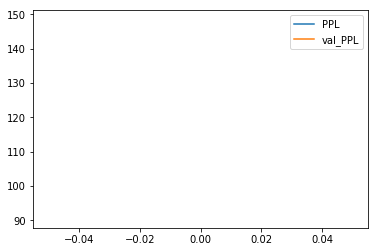

In [20]:
history = pd.DataFrame(hist.history)
print(history.columns)
history.loc[:,['PPL','val_PPL']].tail(4600).plot()

In [21]:
def predict_seq(model, preSeq=None, genLen=seq_len, power=1):
    """ Predict a sequence with length genLen.
        arg:
            model: Keras model used to predict.
            preSeq: list. The leading sequence.
            genLen: float or np.inf. If power is equal to np.inf, then an argmax will be used. 
            power: Probility power.
    """
    preSeq = [word_to_id['<START>']] if preSeq == None else [word_to_id['<START>']] + preSeq   
    pointer = len(preSeq) - 1
    
    for _ in range(genLen):
        inputSeq = np.array([preSeq])
        prob = model.predict(inputSeq)[0, pointer, :]
        if power==np.inf:
            pred = np.argmax(prob)
        else:
            prob = np.power(prob, power)
            prob = prob / np.sum(prob)
            pred = np.random.choice(range(voc_size), p=prob)
        preSeq.append(pred)
        pointer = pointer + 1

    return preSeq, ' '.join([id_to_word[id] for id in preSeq])

In [23]:
_, seq = predict_seq(model, power=1)
seq

"<START> increased N N from some time coca-cola inc. of the company acquired more than terms of its $ N million campaign notably surprised <eos> it 's recently clear how much the evidence has <END> a"